# DATA 612 Project 4 - Accuracy and Beyond

By Mike Silva

## Introduction

This project has two main components.  The first is to assess the accuracy of the recommender system.  Two different algorithms will be evaluated against offline data.

The second component will be an implementation of the goal of increased serendipity, novelty or diversity.  Once this is implemented, I will reevaluate the accuracy of the recommendations.

### About the Book-Crossing Data

The [Book-Crossing data](http://www2.informatik.uni-freiburg.de/~cziegler/BX/) was collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004) from the Book-Crossing community with kind permission from Ron Hornbaker, CTO of Humankind Systems. It contains 278,858 users (anonymized but with some demographic information) and 1,149,780 ratings (explicit & implicit) about 271,379 books.


## Data Acquisition and Exploration

In [1]:
import matplotlib.pyplot as plt
import csv
import os
import numpy as np
import pandas as pd
import requests
import zipfile
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

%matplotlib inline

# STEP 1 - DOWNLOAD THE DATA SET
if not os.path.exists("BX-CSV-Dump.zip"):
    # We need to download it
    response = requests.get("http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip")
    if response.status_code == 200:
        with open("BX-CSV-Dump.zip", "wb") as f:
            f.write(response.content)
# STEP 2 - EXTRACT THE DATA SET
if not os.path.exists("BX-Book-Ratings.csv"):
    with zipfile.ZipFile("BX-CSV-Dump.zip","r") as z:
        z.extractall()
# STEP 3 - READ IN THE DATA
ratings = pd.read_csv("BX-Book-Ratings.csv", sep=";", encoding = "unicode_escape") 

users = pd.read_csv("BX-Users.csv", sep=";", encoding = "unicode_escape") 

# Had to do this the old fashioned way
items = []

with open("BX-Books.csv") as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    for row in reader:
        items.append(row)
        
items = pd.DataFrame(items)
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


I'm going to simplify the data by converting the ISBN and User ID to an index number.  This will be a bit easier to work with than an ISBN

In [2]:
item_index = pd.DataFrame({"ISBN": ratings["ISBN"].unique()}).reset_index().rename(columns={"index": "book_id"})
user_index = pd.DataFrame({"User-ID": ratings["User-ID"].unique()}).reset_index().rename(columns={"index": "user_id"})
ratings = pd.merge(ratings, item_index).drop(columns=["ISBN"])
ratings = pd.merge(ratings, user_index).drop(columns=["User-ID"]).rename(columns={"Book-Rating": "rating"})
ratings

,rating,book_id,user_id
0,0,0,0
1,5,0,1655
2,9,383,1655
3,8,443,1655
4,9,1313,1655
...,...,...,...
1149775,10,340494,105254
1149776,8,340500,105260
1149777,5,340501,105261
1149778,8,340510,105264


There is over one million records here which will be a problem on my computer.  Let's get a quick tally of how many of each ratings are in this data set:

In [4]:
ratings.groupby("rating")["rating"].count()

rating
0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: rating, dtype: int64

Well over 700K are zeros.  The documentation indicates they are implicit ratings.  Let's visualize the non-zero (explicit) ratings.

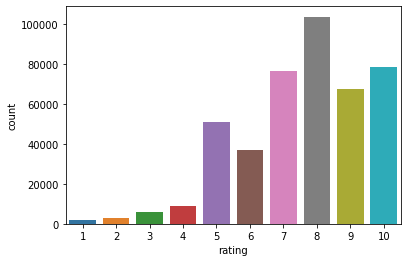

In [5]:
non_zero_ratings = ratings[ratings["rating"] > 0].reset_index(drop=True)
sns.countplot(x="rating", data=non_zero_ratings)

There's quite a few books that received an 8+ rating.  That may be what I will call the "good" recommendations.  Let's see what the average rating is for the non-zero rated books:

In [6]:
average_non_zero_rating = non_zero_ratings["rating"].mean()
average_non_zero_rating

7.601066246071331

I will use 8+ as they have a higher than average rating.  Seven or lower are not desirable recommendations. 

## Recommender System Development

I will develop a SVD recommender system and an item based collaborative filtering recommender system.  As previously noted I have a lot more data here than can fit in the limited memory of my computer.  Let's get a count of how many non-zero ratings I have:

In [7]:
len(non_zero_ratings.index)

433671

### Subsetting the Data

I have over 400K ratings which is too much for my computer to handle.  I know from previous work with the MovieLense 100K data set that my computer can handle it.  There were 8,600 movies and 509 users.  I'm going to try to create a similar sized data set from the books crossing data.

In [8]:
temp = non_zero_ratings.groupby("user_id")["user_id"].count().to_frame().rename(columns={"user_id": "count"}).reset_index()
temp[temp["count"] > 1]['count'].describe()

count    32423.000000
mean        11.975727
std         67.646164
min          2.000000
25%          2.000000
50%          4.000000
75%          9.000000
max       8524.000000
Name: count, dtype: float64

Interesting.  The user that has the most non-zero reviews has reviewed 8,524 books.  I think I will limit the books to just those that has been rated by this ultra-reader.  I will find out who the ultra-reader is:

In [9]:
temp[temp["count"] == 8524]

,user_id,count
3785,5063,8524


In [10]:
book_filter = non_zero_ratings[non_zero_ratings["user_id"] == 5063]["book_id"].to_frame().reset_index(drop=True)
non_zero_ratings = pd.merge(non_zero_ratings, book_filter).reset_index(drop=True)
len(non_zero_ratings.index)

84843

In [21]:
user_filter = non_zero_ratings.groupby("user_id")["user_id"].count().to_frame().rename(columns={"user_id": "count"}).reset_index()
user_filter = user_filter[user_filter["count"] > 14].reset_index(drop=True)
non_zero_ratings = pd.merge(non_zero_ratings, user_filter).reset_index(drop=True)
len(non_zero_ratings.index)

27871

This process left just under 26,000 ratings.  This seems workable.  Let's see how well this subset represents the data:

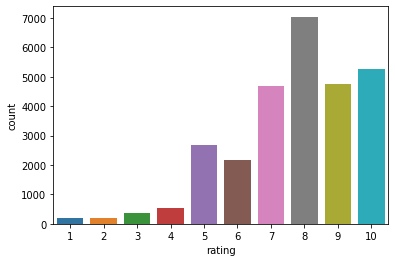

In [22]:
sns.countplot(x="rating", data=non_zero_ratings)

In [23]:
non_zero_ratings["rating"].describe()

count    27871.000000
mean         7.704029
std          1.845966
min          1.000000
25%          7.000000
50%          8.000000
75%          9.000000
max         10.000000
Name: rating, dtype: float64

In [24]:
def train_eval_test_split(df, seed=42):
    ratings_train, temp = train_test_split(df, test_size=0.2, random_state=seed, stratify=df[["rating"]])
    ratings_eval, ratings_test = train_test_split(temp, test_size=0.5, random_state=seed, stratify=temp[["rating"]])
    return (ratings_train, ratings_eval, ratings_test)

ratings_train, ratings_eval, ratings_test = train_eval_test_split(non_zero_ratings)

Now that I have four equally sized data sets, I can test the modeling method against 4 different but similar data sets to see how the model preforms.  Each will be trained on 80% of the non-zero ratings, with 10% for tuning the system and 10% for a test set.

In [25]:
A = ratings_train.pivot(index="user_id", columns="book_id", values="rating").fillna(0)

In [26]:
def get_svd_predictions(A, k):
    """Get ratings predictions using SVD.
        Args:
    A (DataFrame): The user item rating matrix
    k (int): The number of singular values
        Returns:
    predictions_long (DataFrame): Predicted user item rating data frame
    """
    # Account for user bias
    user_ratings_mean = np.mean(A.values, axis=1)
    A = A - user_ratings_mean.reshape(-1, 1)
    # Do the SVD decomposition
    U, sigma, Vt = svds(A, k=k)
    sigma = np.diag(sigma)
    # Build the prediction matrix
    predictions = np.dot(np.dot(U, sigma), Vt)
    # Add back in the user bias
    predictions = predictions + user_ratings_mean.reshape(-1, 1)
    # Let's round it to the nearest integer
    predictions = np.matrix.round(predictions, 0)
    # Make sure values are between 1 and 10
    predictions[predictions < 1] = 1
    predictions[predictions > 10] = 10
    # Return the predictions
    predictions = pd.DataFrame(predictions, index=A.index, columns=A.columns)
    return predictions


predictions = get_svd_predictions(A, 100)
predictions

book_id,2,8,11,13,19,20,25,28,61,73,...,42573,42574,42577,42578,42579,42580,42581,42582,42586,42588
user_id,,,,,,,,,,,,,,,,,,,,,
255,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
522,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1063,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1641,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1831,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104364,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
104367,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
104997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [28]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-100k')

# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
#cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
data

4. As part of your textual conclusion, discuss one or more additional experiments that
could be performed and/or metrics that could be evaluated only if online evaluation
was possible. Also, briefly propose how you would design a reasonable online
evaluation environment. 